In [87]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [88]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [89]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [90]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

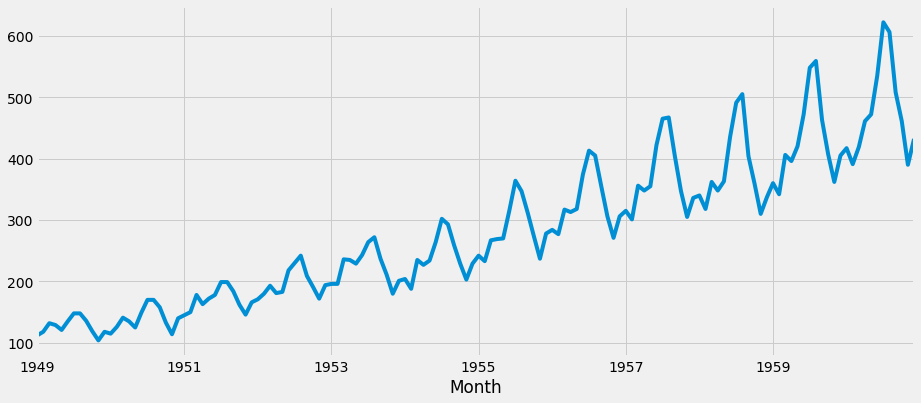

In [91]:
y.plot(figsize=(14, 6))
plt.show()

In [92]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [93]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [94]:
train_size  = int(len(data) * 0.7)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('train size :',train.shape[0])
print('test size  :',test.shape[0])

train size : 100
test size  : 44


In [95]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],2,1,1))
    return dataX, dataY

In [96]:
look_back = 2
trainX, trainY = reshape_data(train, look_back)
testX, testY = reshape_data(test, look_back)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (97, 2, 1, 1)
test shape  : (41, 2, 1, 1)


### Define and Fit  the Model

In [97]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=300, validation_data=(testX, testY), verbose=0)


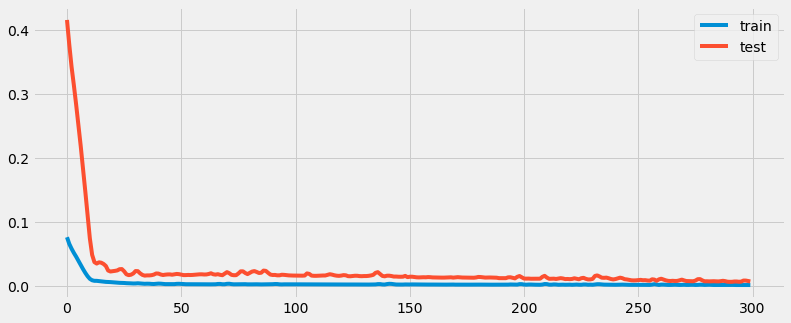

In [98]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [99]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [100]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [101]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.79 RMSE
Test Score: 45.18 RMSE


In [102]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

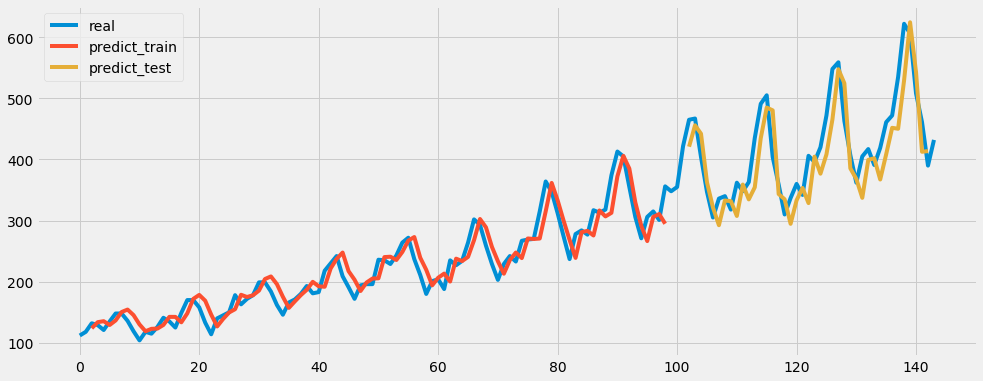

In [103]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data),label = 'real')
plt.plot(trainPredictPlot,label = 'predict_train')
plt.plot(testPredictPlot,label = 'predict_test')
plt.legend()
plt.show()

# SARIMA Model

In [104]:
y_train = y[:'1957-04-02']
y_test  = y['1957-04-02':]

## Grid search the p, d, q parameters

In [107]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [108]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(y_train,order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 1360.8887896501508
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 1124.3605834274476
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 927.015094210419
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 856.8586491342998
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 715.3862543108482
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 2424.05821195876
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 677.6305908202118
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 545.3916144454995
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 2208.5967678581574
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 708.3477980505883
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 677.035732345672
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 593.8024898311235
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 686.6828938232255
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 636.5755932113505
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 519.1095139949875
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 560.8824483068595
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 546.1873082653859
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 2155.12356

ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 544.6186194600275
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 2319.3393468590357
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 502.7618229975167
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 463.38935459352274
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 366.15810794511674
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 550.2292931932892
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 549.6804388200457
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 521.2594228019888
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 481.5615437418056
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 480.4441312047983
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 2297.910815235261
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 397.83895487175175
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 396.0449624511043
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 361.83513467200925
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 935.7029301759394
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 780.136122490626
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC: 662.6999291992097
ARIMA(0, 2, 0) x (0, 1, 0, 12) - AIC: 717.21

ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 392.6109506118949
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 382.2291291697409
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 876.9076888807575
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 734.0070368200467
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 612.0946037500729
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 636.4849253123828
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 551.0832907310012
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 2399.123560063671
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 609.3759165507955
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 468.9683046918148
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 2061.190130313092
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 640.3677020174823
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 608.0075736307288
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 532.4256812380926
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 565.309525509697
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC: 551.626577655363
ARIMA(1, 0, 2) x (1, 1, 2, 12) - AIC: 464.6258742246681
ARIMA(1, 0, 2) x (1, 2, 0, 12) - AIC: 501.49430481

ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 611.6176098950627
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 535.5025547816994
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 552.9766932041256
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 545.7508722716291
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 2639.5578757600615
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 491.2749850553032
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 469.8270869517844
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 370.1643729766263
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 541.9735185694279
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 542.058647439723
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 528.7032672631262
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 468.8845815932401
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 468.73184890908
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 2557.6191801549157
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 385.4185584373971
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 383.92874048389297
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC: 371.17663817953155
ARIMA(1, 2, 2) x (0, 0, 0, 12) - AIC: 870.68089

ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 466.82784436981615
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 2468.1598100950387
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 380.55850995138854
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 377.1352856633198
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 374.3425598887755
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 880.6483319770284
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 730.3673047559397
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 611.9959003684357
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 636.1020777571074
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 550.4167111854011
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 4756.928581041132
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 615.6338680680619
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 470.9848304113618
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 2450.3971316656257
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC: 633.3817185807744
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 613.1910096463077
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC: 538.0273486361424
ARIMA(2, 1, 1) x (1, 1, 0, 12) - AIC: 549.58

## Plot model diagnostics

In [109]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(best_result[0][0], best_result[0][1], best_result[0][2]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 2, 2)x(2, 2, 2, 12)   Log Likelihood                -172.845
Date:                            Mon, 11 May 2020   AIC                            359.690
Time:                                    19:58:47   BIC                            372.641
Sample:                                01-01-1949   HQIC                           364.564
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3394   3101.202     -0.000      1.000   -6079.584    6076.905
ma.L2          0.3394   1052.456   

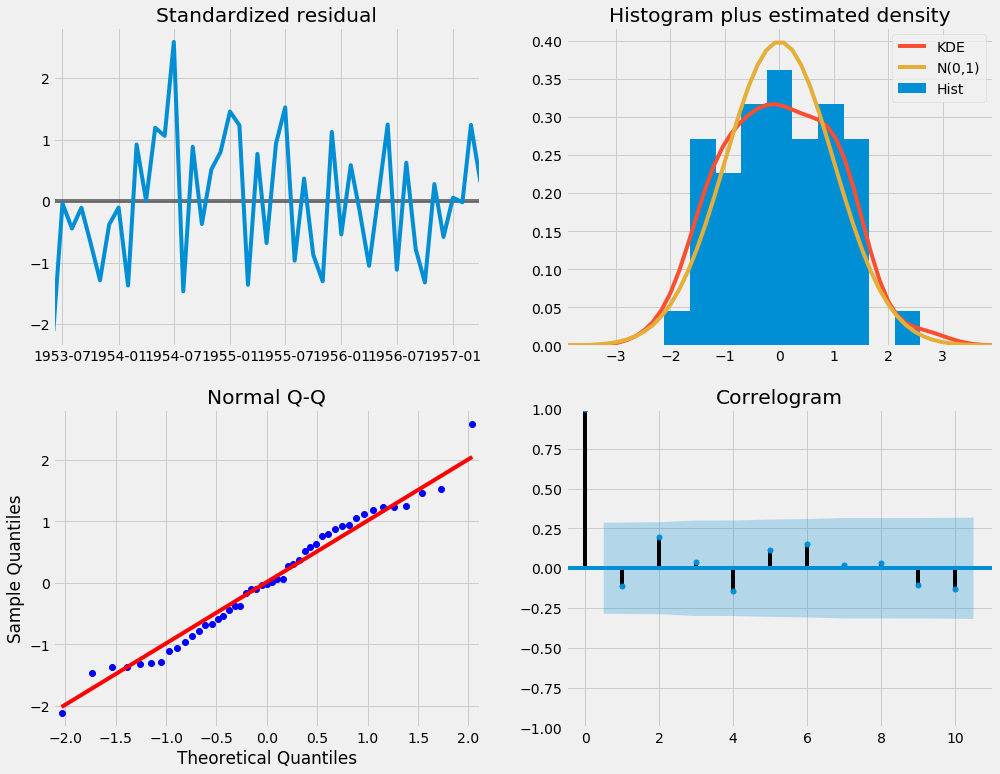

In [110]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [111]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1949-02-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

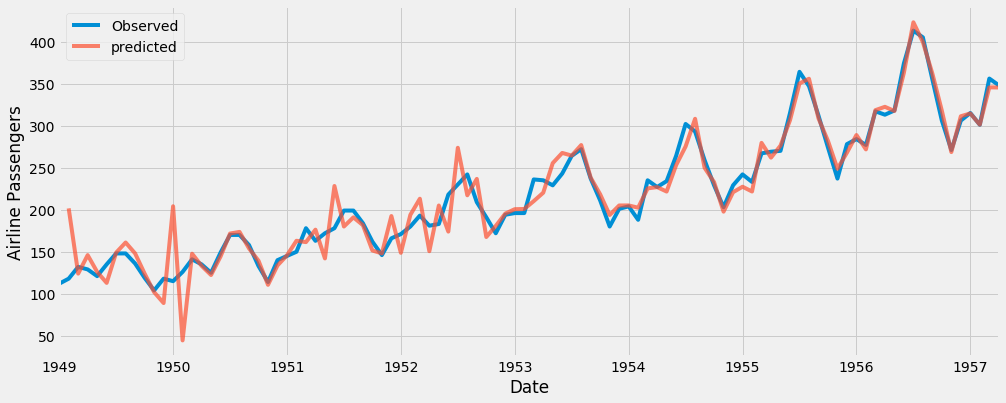

In [112]:
ax = y_train.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [113]:
pred_uc = results.get_forecast(steps=44)

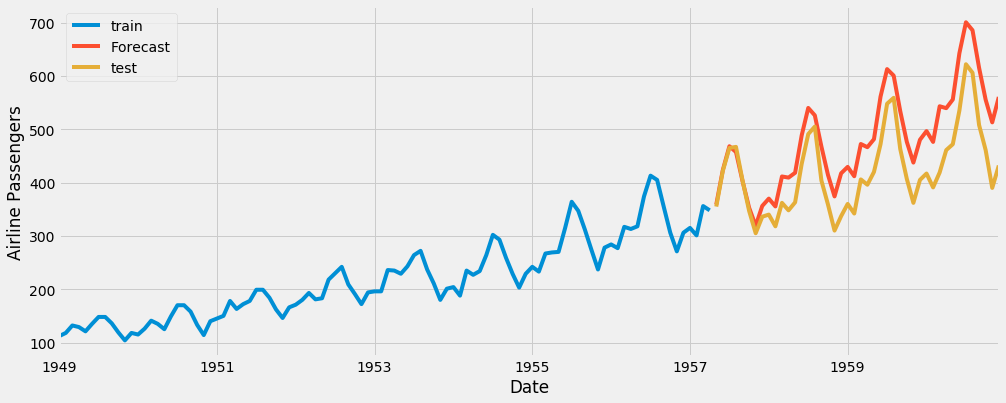

In [114]:
ax = y_train.plot(label='train', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
y_test.plot(ax=ax, label='test')
ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()
plt.show()

In [115]:
math.sqrt(mean_squared_error(y_test, pred_uc.predicted_mean))

69.46131367191484